# R-CNN Training Pipeline for Airbus Aircraft Detection

Implementation of R-CNN (Girshick et al., 2014) on Airbus aircraft dataset.

## Setup and Imports

In [ ]:
from __future__ import annotations

import sys
import os
import random
import json
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

sys.path.insert(0, str(Path.cwd() / "rcnn"))

from rcnn.config.config import RCNNConfig
from rcnn.models.cnn import AlexNetFeatureExtractor
from rcnn.data import create_rcnn_dataloaders

sns.set_context("talk")
sns.set_style("whitegrid")

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Using device: {DEVICE}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using device: {DEVICE}")
    print(f"Apple Silicon GPU acceleration enabled")
else:
    DEVICE = torch.device("cpu")
    print(f"Using device: {DEVICE}")
    print("Note: Training will be slow on CPU. Consider using a GPU-enabled system.")

Using device: mps
Apple Silicon GPU acceleration enabled


## Configuration

In [ ]:
# Paths
BASE_DIR = Path("dataset/airbus-aircrafts-sample-dataset")
ANNOTATIONS_CSV = BASE_DIR / "annotations.csv"
IMAGES_DIR = BASE_DIR / "images"
ARTIFACTS_DIR = Path("artifacts/rcnn")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

config = RCNNConfig()

print("R-CNN Configuration:")
print(f"  Region proposals per image: {config.num_proposals}")
print(f"  Input size: {config.input_size}")
print(f"  Context padding: {config.context_padding} pixels")
print(f"  Feature layer: {config.feature_layer}")
print(f"\nFine-tuning parameters:")
print(f"  Learning rate: {config.finetune_learning_rate}")
print(f"  Batch size: {config.finetune_batch_size} (32 pos + 96 neg)")
print(f"  IoU threshold: {config.finetune_iou_threshold}")
print(f"  Epochs: {config.finetune_epochs}")
print(f"\nDataset:")
print(f"  Annotations: {ANNOTATIONS_CSV}")
print(f"  Images: {IMAGES_DIR}")
print(f"  Output: {ARTIFACTS_DIR}")

R-CNN Configuration:
  Region proposals per image: 2000
  Input size: (227, 227)
  Context padding: 16 pixels
  Feature layer: fc7

Fine-tuning parameters:
  Learning rate: 0.001
  Batch size: 128 (32 pos + 96 neg)
  IoU threshold: 0.5
  Epochs: 50

Dataset:
  Annotations: dataset/airbus-aircrafts-sample-dataset/annotations.csv
  Images: dataset/airbus-aircrafts-sample-dataset/images
  Output: artifacts/rcnn


## Dataset Exploration

In [ ]:
annotations = pd.read_csv(ANNOTATIONS_CSV)
print(f"Total annotations: {len(annotations):,}")
print(f"Unique images: {annotations['image_id'].nunique()}")
print(f"\nClass distribution:")
print(annotations['class'].value_counts())

objects_per_image = annotations.groupby('image_id').size()
print(f"\nObjects per image:")
print(f"  Mean: {objects_per_image.mean():.1f}")
print(f"  Median: {objects_per_image.median():.0f}")
print(f"  Min: {objects_per_image.min()}")
print(f"  Max: {objects_per_image.max()}")

annotations.head()

Total annotations: 3,425
Unique images: 103

Class distribution:
class
Airplane              3316
Truncated_airplane     109
Name: count, dtype: int64

Objects per image:
  Mean: 33.3
  Median: 30
  Min: 5
  Max: 92


id                                  image_id  \
0   1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1   2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2   3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3   4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4   5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   

                                            geometry     class  
0  [(135, 522), (245, 522), (245, 600), (135, 600...  Airplane  
1  [(1025, 284), (1125, 284), (1125, 384), (1025,...  Airplane  
2  [(1058, 1503), (1130, 1503), (1130, 1568), (10...  Airplane  
3  [(813, 1518), (885, 1518), (885, 1604), (813, ...  Airplane  
4  [(594, 938), (657, 938), (657, 1012), (594, 10...  Airplane

### Visualize objects per image distribution

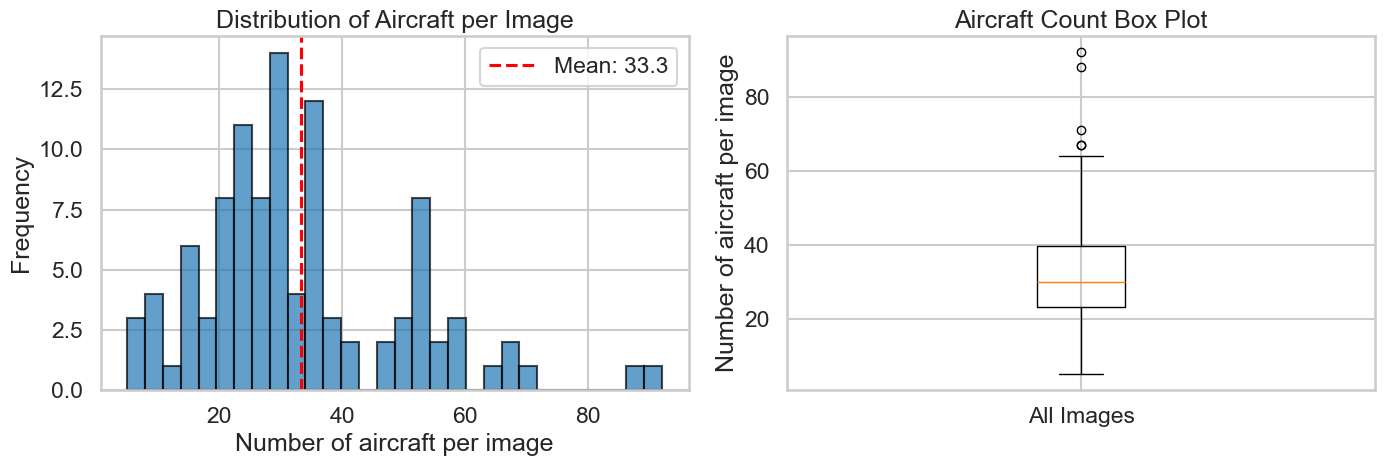

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(objects_per_image, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of aircraft per image')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Aircraft per Image')
axes[0].axvline(objects_per_image.mean(), color='red', linestyle='--', 
                label=f'Mean: {objects_per_image.mean():.1f}')
axes[0].legend()

axes[1].boxplot(objects_per_image, vert=True)
axes[1].set_ylabel('Number of aircraft per image')
axes[1].set_title('Aircraft Count Box Plot')
axes[1].set_xticklabels(['All Images'])

plt.tight_layout()
plt.show()

### Sample images with annotations

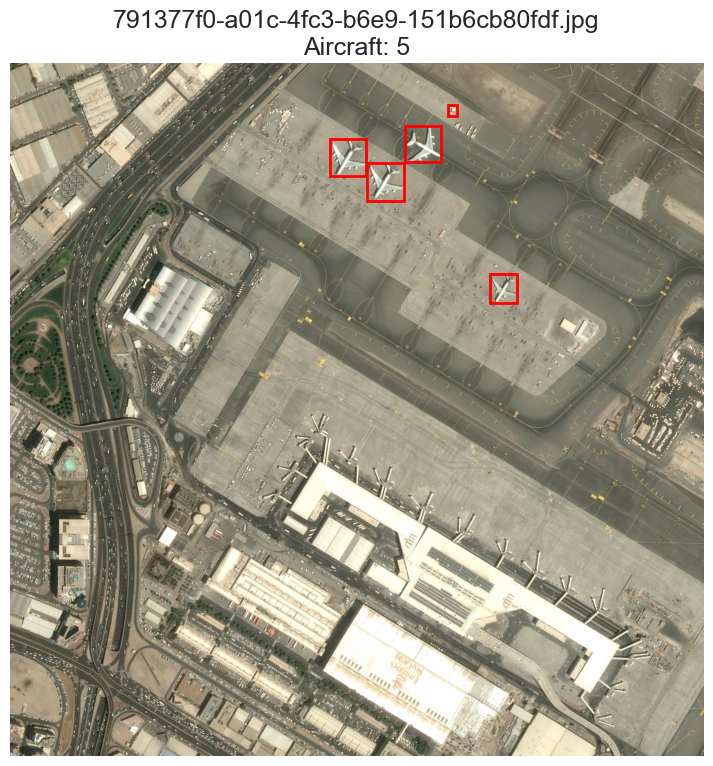

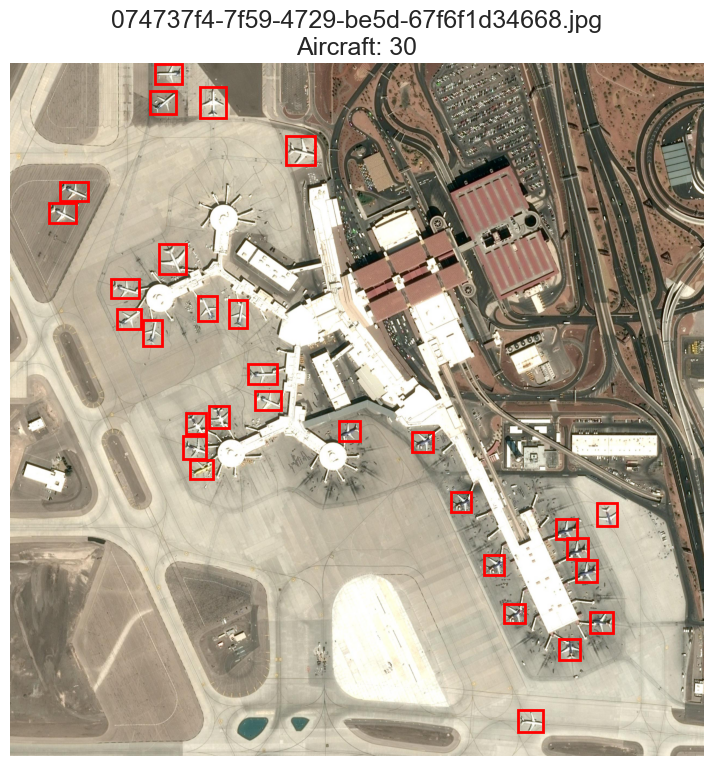

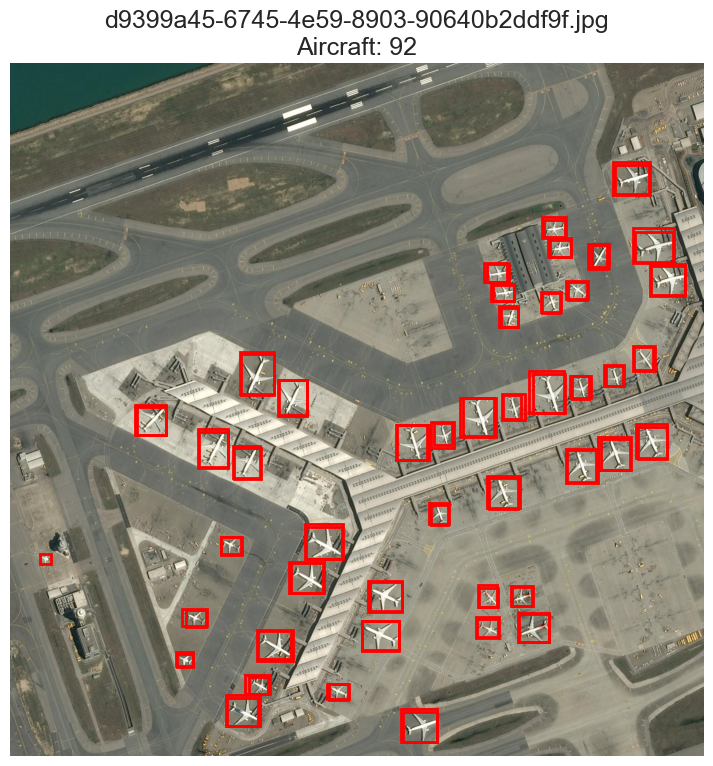

In [ ]:
from ast import literal_eval
import matplotlib.patches as patches

def polygon_to_bbox(geometry: str):
    """Convert polygon string to [x1, y1, x2, y2]."""
    coords = literal_eval(geometry)
    xs = [pt[0] for pt in coords]
    ys = [pt[1] for pt in coords]
    return [min(xs), min(ys), max(xs), max(ys)]

def visualize_image_with_boxes(image_id: str, annotations: pd.DataFrame):
    """Visualize image with bounding boxes."""
    image_path = IMAGES_DIR / image_id
    img = Image.open(image_path)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    
    # Draw boxes
    image_annotations = annotations[annotations['image_id'] == image_id]
    for _, row in image_annotations.iterrows():
        bbox = polygon_to_bbox(row['geometry'])
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
    
    ax.set_title(f'{image_id}\nAircraft: {len(image_annotations)}')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

median_value = objects_per_image.median()
median_image_id = (objects_per_image - median_value).abs().idxmin()

sample_images = [
    objects_per_image.idxmin(),
    median_image_id,
    objects_per_image.idxmax(),
]

for img_id in sample_images:
    visualize_image_with_boxes(img_id, annotations)

## Create Dataloaders

This will:
1. Generate ~2000 proposals per image using Selective Search
2. Compute IoU with ground truth boxes
3. Assign labels based on IoU ≥ 0.5
4. Create stratified batches (32 positive + 96 negative)

In [6]:
print("Creating dataloaders...")
print("This may take several minutes as proposals are being generated...\n")

train_loader, val_loader = create_rcnn_dataloaders(
    annotations_csv=ANNOTATIONS_CSV,
    images_dir=IMAGES_DIR,
    stage="finetune",
    batch_size=config.finetune_batch_size,
    num_positive_per_batch=32,
    num_workers=4,
    train_val_split=0.8,
)

print(f"\n{'='*60}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Total train samples per epoch: {len(train_loader) * config.finetune_batch_size}")
print(f"Total val samples: ~{len(val_loader) * config.finetune_batch_size}")
print(f"{'='*60}")

Creating dataloaders...
This may take several minutes as proposals are being generated...

Building proposal index for stage: finetune
Total images to process: 82

[1/82] Processing: 4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg (generating proposals...) done
[2/82] Processing: 4e8c95f3-bbb6-4e2f-920d-8d3b2bd1d29f.jpg (generating proposals...) done
[3/82] Processing: 72fa2a77-cf8e-44a2-9ab2-f11ca63b4b72.jpg (generating proposals...) done
[4/82] Processing: 2314c1b5-ec8f-4212-b42f-43365a13fd20.jpg (generating proposals...) done
[5/82] Processing: 0641acc3-c0b9-4f9d-b0ba-7ad18aa08864.jpg (generating proposals...) done
[6/82] Processing: 3463b88d-1e11-4c04-9868-e8c72d510556.jpg (generating proposals...) done
[7/82] Processing: 1e7e0450-6eb3-479e-88c2-990abc8207fa.jpg (generating proposals...) done
[8/82] Processing: 12210ad7-83f8-4b54-bb4b-e93f8ff6ac1f.jpg (generating proposals...) done
[9/82] Processing: e5416a97-a8ea-415f-928a-e75a5090cd46.jpg (generating proposals...) done
[10/82] Processin

### Inspect a batch

In [7]:
# Get a sample batch
sample_batch = next(iter(train_loader))

print(f"Batch contents:")
print(f"  Images shape: {sample_batch['image'].shape}")
print(f"  Labels shape: {sample_batch['label'].shape}")
print(f"  IoUs shape: {sample_batch['iou'].shape}")

# Check batch composition
labels = sample_batch['label']
num_positive = (labels == 1).sum().item()
num_negative = (labels == 0).sum().item()

print(f"\nBatch composition:")
print(f"  Positive (aircraft): {num_positive}")
print(f"  Negative (background): {num_negative}")
print(f"  Total: {len(labels)}")

# IoU statistics for positives
positive_ious = sample_batch['iou'][labels == 1]
print(f"\nPositive IoU statistics:")
print(f"  Mean: {positive_ious.mean():.3f}")
print(f"  Min: {positive_ious.min():.3f}")
print(f"  Max: {positive_ious.max():.3f}")

/Users/danylolitvinchuk/python-workspace/NN-Lab2/myenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch contents:
  Images shape: torch.Size([128, 3, 227, 227])
  Labels shape: torch.Size([128])
  IoUs shape: torch.Size([128])

Batch composition:
  Positive (aircraft): 32
  Negative (background): 96
  Total: 128

Positive IoU statistics:
  Mean: 0.691
  Min: 0.505
  Max: 0.884


### Visualize sample proposals

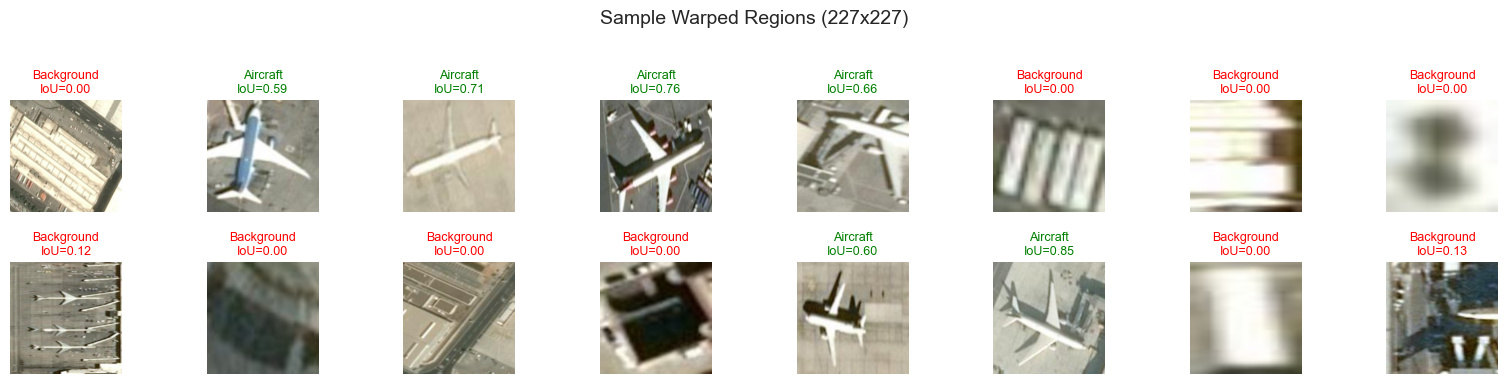

In [8]:
# Visualize some warped regions
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
axes = axes.flatten()

# Denormalize images
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for idx in range(16):
    img = sample_batch['image'][idx]
    label = sample_batch['label'][idx].item()
    iou = sample_batch['iou'][idx].item()
    
    # Denormalize
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    
    axes[idx].imshow(img)
    color = 'green' if label == 1 else 'red'
    label_text = 'Aircraft' if label == 1 else 'Background'
    axes[idx].set_title(f'{label_text}\nIoU={iou:.2f}', color=color, fontsize=9)
    axes[idx].axis('off')

plt.suptitle('Sample Warped Regions (227x227)', fontsize=14)
plt.tight_layout()
plt.show()

## Initialize Model

Load ImageNet pre-trained AlexNet and replace final layer for (N+1)-way classification.

In [ ]:
print("Loading pre-trained AlexNet...")

model = AlexNetFeatureExtractor(
    pretrained=True,
    feature_layer=config.feature_layer,
    num_classes=config.num_classes
)

model = model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Feature layer: {config.feature_layer} (4096-dim)")
print(f"  Output classes: {config.num_classes + 1} (aircraft + background)")

Loading pre-trained AlexNet...

Model architecture:
  Total parameters: 61,109,034
  Trainable parameters: 61,109,034
  Feature layer: fc7 (4096-dim)
  Output classes: 2 (aircraft + background)


## Training Setup

In [ ]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=config.finetune_learning_rate,
    momentum=0.9,
    weight_decay=0.0005
)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=15,
    gamma=0.1
)

print(f"Training configuration:")
print(f"  Optimizer: SGD")
print(f"  Learning rate: {config.finetune_learning_rate}")
print(f"  Momentum: 0.9")
print(f"  Weight decay: 0.0005")
print(f"  Epochs: {config.finetune_epochs}")
print(f"  LR schedule: Step decay (0.1x every 15 epochs)")

Training configuration:
  Optimizer: SGD
  Learning rate: 0.001
  Momentum: 0.9
  Weight decay: 0.0005
  Epochs: 50
  LR schedule: Step decay (0.1x every 15 epochs)


## Training Loop with Logging

**Paper reference:** Section 2.3 - Domain-specific fine-tuning
> "To adapt our CNN to the new task (detection) and the new domain (warped proposal windows), 
> we continue stochastic gradient descent (SGD) training of the CNN parameters using only warped region proposals."

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)
        
        # Forward pass
        logits = model(images, extract_features=False)
        loss = criterion(logits, labels)
        
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # Statistics
        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        _, predicted = logits.max(1)
        total += batch_size
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate on validation set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Per-class statistics
    class_correct = [0, 0]  # [background, aircraft]
    class_total = [0, 0]
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Validation', leave=False):
            images = batch['image'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            logits = model(images, extract_features=False)
            loss = criterion(logits, labels)
            
            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = logits.max(1)
            total += batch_size
            correct += predicted.eq(labels).sum().item()
            
            # Per-class accuracy
            for c in [0, 1]:
                mask = labels == c
                class_correct[c] += (predicted[mask] == labels[mask]).sum().item()
                class_total[c] += mask.sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    # Per-class accuracy
    bg_acc = 100. * class_correct[0] / class_total[0] if class_total[0] > 0 else 0
    aircraft_acc = 100. * class_correct[1] / class_total[1] if class_total[1] > 0 else 0
    
    return epoch_loss, epoch_acc, bg_acc, aircraft_acc

### Run Training

In [12]:
# Training history
history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_bg_acc': [],
    'val_aircraft_acc': [],
    'lr': [],
}

best_val_acc = 0.0
best_epoch = 0

print("\n" + "="*60)
print("Starting R-CNN Fine-tuning")
print("="*60 + "\n")

for epoch in range(1, config.finetune_epochs + 1):
    print(f"Epoch {epoch}/{config.finetune_epochs}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, val_acc, val_bg_acc, val_aircraft_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log metrics
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_bg_acc'].append(val_bg_acc)
    history['val_aircraft_acc'].append(val_aircraft_acc)
    history['lr'].append(current_lr)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Background Acc: {val_bg_acc:.2f}%")
    print(f"  Aircraft Acc:   {val_aircraft_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_path = ARTIFACTS_DIR / "finetuned_cnn_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': config,
        }, best_path)
        print(f"✓ Saved best model (val_acc={val_acc:.2f}%)")
    
    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        checkpoint_path = ARTIFACTS_DIR / f"finetuned_cnn_epoch{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': config,
        }, checkpoint_path)
        print(f"✓ Saved checkpoint")
    
    print()

# Save final model
final_path = ARTIFACTS_DIR / "finetuned_cnn_final.pth"
torch.save({
    'epoch': config.finetune_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'config': config,
}, final_path)

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(ARTIFACTS_DIR / "training_history.csv", index=False)

print("="*60)
print("Training Complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
print(f"Models saved to: {ARTIFACTS_DIR}")
print("="*60)


Starting R-CNN Fine-tuning

Epoch 1/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:04<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.1228 | Train Acc: 94.85%
Val Loss:   0.0452 | Val Acc:   98.35%
  Background Acc: 98.38%
  Aircraft Acc:   95.84%
Learning Rate: 0.001000
✓ Saved best model (val_acc=98.35%)

Epoch 2/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0609 | Train Acc: 97.79%
Val Loss:   0.0213 | Val Acc:   99.21%
  Background Acc: 99.29%
  Aircraft Acc:   91.68%
Learning Rate: 0.001000
✓ Saved best model (val_acc=99.21%)

Epoch 3/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0465 | Train Acc: 98.44%
Val Loss:   0.0270 | Val Acc:   99.05%
  Background Acc: 99.08%
  Aircraft Acc:   96.28%
Learning Rate: 0.001000

Epoch 4/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0333 | Train Acc: 98.74%
Val Loss:   0.0414 | Val Acc:   98.65%
  Background Acc: 98.66%
  Aircraft Acc:   97.59%
Learning Rate: 0.001000

Epoch 5/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0357 | Train Acc: 98.94%
Val Loss:   0.0305 | Val Acc:   98.98%
  Background Acc: 99.00%
  Aircraft Acc:   96.72%
Learning Rate: 0.001000

Epoch 6/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:05<?, ?it/s]

Train Loss: 0.0338 | Train Acc: 98.90%
Val Loss:   0.0498 | Val Acc:   98.30%
  Background Acc: 98.31%
  Aircraft Acc:   98.03%
Learning Rate: 0.001000

Epoch 7/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0273 | Train Acc: 99.05%
Val Loss:   0.0334 | Val Acc:   98.87%
  Background Acc: 98.89%
  Aircraft Acc:   97.59%
Learning Rate: 0.001000

Epoch 8/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0364 | Train Acc: 98.83%
Val Loss:   0.0136 | Val Acc:   99.54%
  Background Acc: 99.63%
  Aircraft Acc:   90.81%
Learning Rate: 0.001000
✓ Saved best model (val_acc=99.54%)

Epoch 9/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0293 | Train Acc: 99.03%
Val Loss:   0.0171 | Val Acc:   99.41%
  Background Acc: 99.49%
  Aircraft Acc:   92.34%
Learning Rate: 0.001000

Epoch 10/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0290 | Train Acc: 99.12%
Val Loss:   0.0253 | Val Acc:   99.13%
  Background Acc: 99.17%
  Aircraft Acc:   95.19%
Learning Rate: 0.001000
✓ Saved checkpoint

Epoch 11/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:05<?, ?it/s]

Train Loss: 0.0230 | Train Acc: 99.32%
Val Loss:   0.0336 | Val Acc:   98.89%
  Background Acc: 98.91%
  Aircraft Acc:   97.16%
Learning Rate: 0.001000

Epoch 12/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0234 | Train Acc: 99.28%
Val Loss:   0.0233 | Val Acc:   99.20%
  Background Acc: 99.23%
  Aircraft Acc:   96.50%
Learning Rate: 0.001000

Epoch 13/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:05<?, ?it/s]

Train Loss: 0.0227 | Train Acc: 99.28%
Val Loss:   0.0160 | Val Acc:   99.47%
  Background Acc: 99.53%
  Aircraft Acc:   93.65%
Learning Rate: 0.001000

Epoch 14/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0237 | Train Acc: 99.28%
Val Loss:   0.0292 | Val Acc:   99.05%
  Background Acc: 99.06%
  Aircraft Acc:   97.59%
Learning Rate: 0.001000

Epoch 15/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0227 | Train Acc: 99.32%
Val Loss:   0.0187 | Val Acc:   99.37%
  Background Acc: 99.42%
  Aircraft Acc:   94.97%
Learning Rate: 0.000100

Epoch 16/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0233 | Train Acc: 99.37%
Val Loss:   0.0181 | Val Acc:   99.38%
  Background Acc: 99.43%
  Aircraft Acc:   94.53%
Learning Rate: 0.000100

Epoch 17/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0195 | Train Acc: 99.45%
Val Loss:   0.0203 | Val Acc:   99.32%
  Background Acc: 99.36%
  Aircraft Acc:   95.40%
Learning Rate: 0.000100

Epoch 18/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0168 | Train Acc: 99.46%
Val Loss:   0.0220 | Val Acc:   99.28%
  Background Acc: 99.32%
  Aircraft Acc:   95.84%
Learning Rate: 0.000100

Epoch 19/50
------------------------------------------------------------


Training:   0%|          | 0/62 [07:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0183 | Train Acc: 99.47%
Val Loss:   0.0218 | Val Acc:   99.29%
  Background Acc: 99.33%
  Aircraft Acc:   95.84%
Learning Rate: 0.000100

Epoch 20/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:24<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0181 | Train Acc: 99.51%
Val Loss:   0.0196 | Val Acc:   99.36%
  Background Acc: 99.40%
  Aircraft Acc:   95.40%
Learning Rate: 0.000100
✓ Saved checkpoint

Epoch 21/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:04<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0223 | Train Acc: 99.41%
Val Loss:   0.0193 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   95.40%
Learning Rate: 0.000100

Epoch 22/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:24<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0173 | Train Acc: 99.52%
Val Loss:   0.0199 | Val Acc:   99.35%
  Background Acc: 99.39%
  Aircraft Acc:   95.40%
Learning Rate: 0.000100

Epoch 23/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0188 | Train Acc: 99.48%
Val Loss:   0.0185 | Val Acc:   99.39%
  Background Acc: 99.44%
  Aircraft Acc:   94.75%
Learning Rate: 0.000100

Epoch 24/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0187 | Train Acc: 99.52%
Val Loss:   0.0187 | Val Acc:   99.38%
  Background Acc: 99.43%
  Aircraft Acc:   94.97%
Learning Rate: 0.000100

Epoch 25/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0209 | Train Acc: 99.42%
Val Loss:   0.0176 | Val Acc:   99.41%
  Background Acc: 99.46%
  Aircraft Acc:   94.75%
Learning Rate: 0.000100

Epoch 26/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0170 | Train Acc: 99.56%
Val Loss:   0.0206 | Val Acc:   99.32%
  Background Acc: 99.36%
  Aircraft Acc:   95.84%
Learning Rate: 0.000100

Epoch 27/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0162 | Train Acc: 99.52%
Val Loss:   0.0203 | Val Acc:   99.32%
  Background Acc: 99.36%
  Aircraft Acc:   95.62%
Learning Rate: 0.000100

Epoch 28/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0217 | Train Acc: 99.31%
Val Loss:   0.0168 | Val Acc:   99.43%
  Background Acc: 99.49%
  Aircraft Acc:   94.31%
Learning Rate: 0.000100

Epoch 29/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0170 | Train Acc: 99.61%
Val Loss:   0.0194 | Val Acc:   99.34%
  Background Acc: 99.39%
  Aircraft Acc:   95.19%
Learning Rate: 0.000100

Epoch 30/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0171 | Train Acc: 99.56%
Val Loss:   0.0176 | Val Acc:   99.40%
  Background Acc: 99.46%
  Aircraft Acc:   94.31%
Learning Rate: 0.000010
✓ Saved checkpoint

Epoch 31/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0185 | Train Acc: 99.53%
Val Loss:   0.0178 | Val Acc:   99.40%
  Background Acc: 99.45%
  Aircraft Acc:   94.53%
Learning Rate: 0.000010

Epoch 32/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0280 | Train Acc: 99.16%
Val Loss:   0.0176 | Val Acc:   99.40%
  Background Acc: 99.46%
  Aircraft Acc:   94.31%
Learning Rate: 0.000010

Epoch 33/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0188 | Train Acc: 99.53%
Val Loss:   0.0177 | Val Acc:   99.40%
  Background Acc: 99.46%
  Aircraft Acc:   94.31%
Learning Rate: 0.000010

Epoch 34/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0185 | Train Acc: 99.52%
Val Loss:   0.0179 | Val Acc:   99.39%
  Background Acc: 99.44%
  Aircraft Acc:   94.53%
Learning Rate: 0.000010

Epoch 35/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0186 | Train Acc: 99.52%
Val Loss:   0.0183 | Val Acc:   99.38%
  Background Acc: 99.43%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 36/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0175 | Train Acc: 99.47%
Val Loss:   0.0185 | Val Acc:   99.37%
  Background Acc: 99.42%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 37/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0180 | Train Acc: 99.48%
Val Loss:   0.0187 | Val Acc:   99.37%
  Background Acc: 99.42%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 38/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0185 | Train Acc: 99.56%
Val Loss:   0.0191 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 39/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0178 | Train Acc: 99.53%
Val Loss:   0.0190 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 40/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0184 | Train Acc: 99.50%
Val Loss:   0.0190 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010
✓ Saved checkpoint

Epoch 41/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0171 | Train Acc: 99.56%
Val Loss:   0.0191 | Val Acc:   99.35%
  Background Acc: 99.40%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 42/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0209 | Train Acc: 99.45%
Val Loss:   0.0184 | Val Acc:   99.38%
  Background Acc: 99.43%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 43/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0159 | Train Acc: 99.53%
Val Loss:   0.0186 | Val Acc:   99.37%
  Background Acc: 99.42%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 44/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0164 | Train Acc: 99.48%
Val Loss:   0.0189 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000010

Epoch 45/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0196 | Train Acc: 99.42%
Val Loss:   0.0189 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000001

Epoch 46/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0165 | Train Acc: 99.45%
Val Loss:   0.0188 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000001

Epoch 47/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:04<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0197 | Train Acc: 99.46%
Val Loss:   0.0188 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000001

Epoch 48/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0182 | Train Acc: 99.50%
Val Loss:   0.0188 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000001

Epoch 49/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:25<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0169 | Train Acc: 99.41%
Val Loss:   0.0188 | Val Acc:   99.36%
  Background Acc: 99.41%
  Aircraft Acc:   94.97%
Learning Rate: 0.000001

Epoch 50/50
------------------------------------------------------------


Training:   0%|          | 0/62 [00:05<?, ?it/s]

Validation:   0%|          | 0/329 [00:04<?, ?it/s]

Train Loss: 0.0229 | Train Acc: 99.29%
Val Loss:   0.0187 | Val Acc:   99.37%
  Background Acc: 99.42%
  Aircraft Acc:   94.97%
Learning Rate: 0.000001
✓ Saved checkpoint

Training Complete!
Best validation accuracy: 99.54% (epoch 8)
Models saved to: artifacts/rcnn


## Training Metrics Visualization

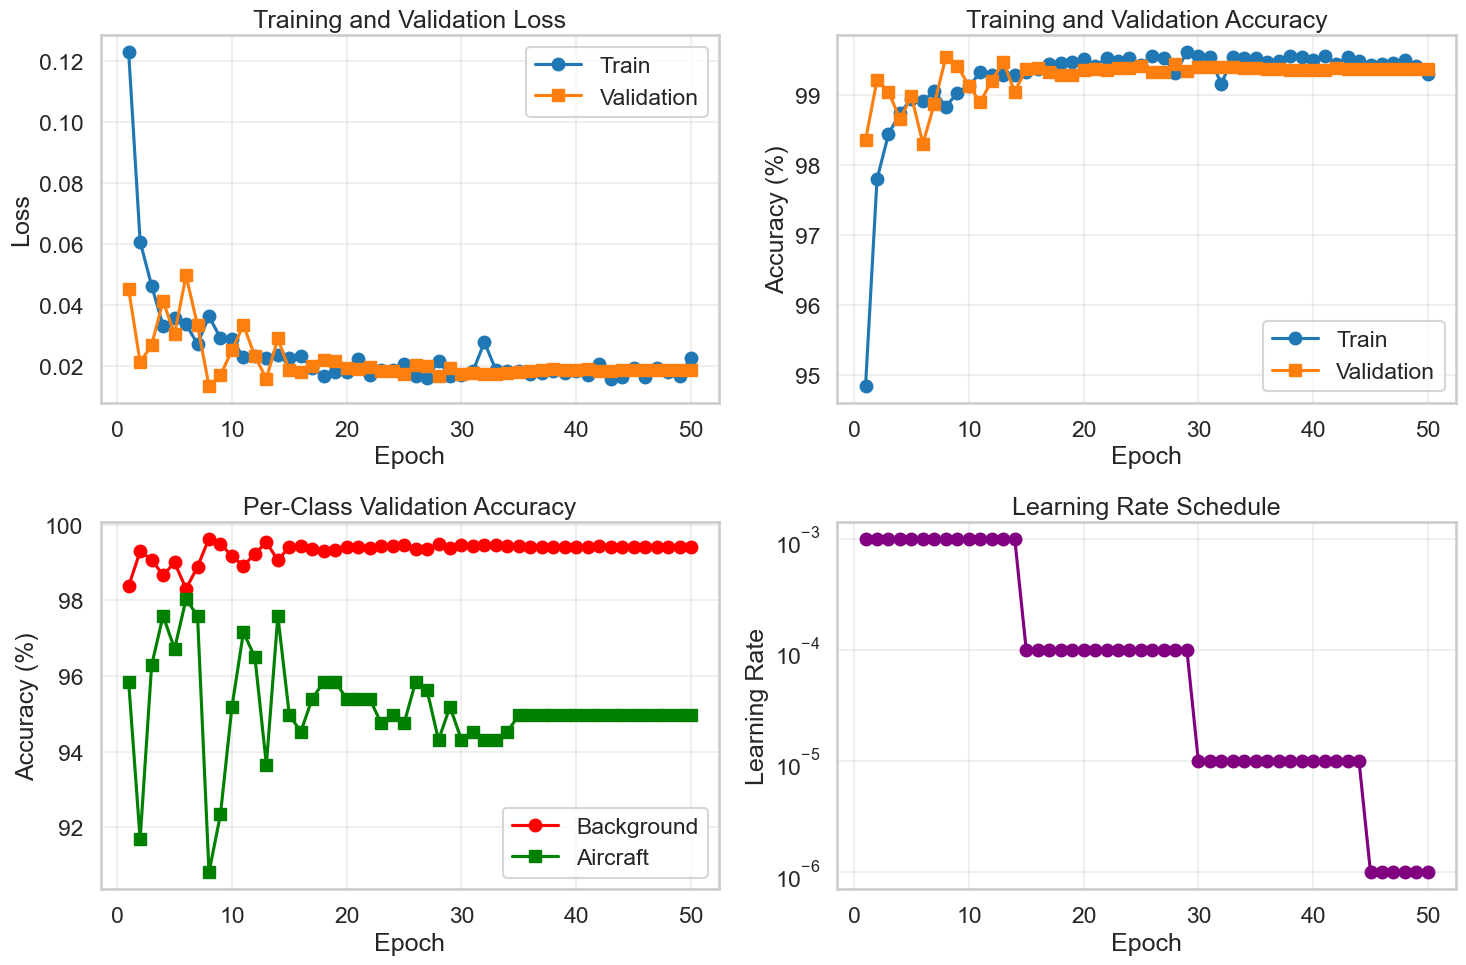

Training curves saved to: artifacts/rcnn/training_curves.png


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts/rcnn")
history_csv_path = ARTIFACTS_DIR / "training_history.csv"

if history_csv_path.exists():
    history_df = pd.read_csv(history_csv_path)
else:
    history_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], label='Train', marker='o')
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Validation', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(history_df['epoch'], history_df['train_acc'], label='Train', marker='o')
axes[0, 1].plot(history_df['epoch'], history_df['val_acc'], label='Validation', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Per-class accuracy
axes[1, 0].plot(history_df['epoch'], history_df['val_bg_acc'], 
                label='Background', marker='o', color='red')
axes[1, 0].plot(history_df['epoch'], history_df['val_aircraft_acc'], 
                label='Aircraft', marker='s', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Per-Class Validation Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 1].plot(history_df['epoch'], history_df['lr'], marker='o', color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to: {ARTIFACTS_DIR / 'training_curves.png'}")

## Training Summary

In [10]:
# ============================================================================
# STANDALONE TRAINING SUMMARY (loads from saved files, no need to run training)
# ============================================================================

from pathlib import Path
import json
import pandas as pd

ARTIFACTS_DIR = Path("artifacts/rcnn")
BASE_DIR = Path("dataset/airbus-aircrafts-sample-dataset")
ANNOTATIONS_CSV = BASE_DIR / "annotations.csv"

# Load saved config
config_path = ARTIFACTS_DIR / "rcnn_config.json"
if config_path.exists():
    with open(config_path, 'r') as f:
        saved_config = json.load(f)
else:
    print("⚠️  Config not found. Using defaults.")
    saved_config = {'num_classes': 1, 'feature_layer': 'fc7'}

# Load training history
history_path = ARTIFACTS_DIR / "training_history.csv"
if history_path.exists():
    history_df = pd.read_csv(history_path)
    best_epoch = history_df['val_acc'].idxmax() + 1
    best_val_acc = history_df['val_acc'].max()
else:
    print("⚠️  Training history not found. Run training first.")
    history_df = None

# Load dataset stats
if ANNOTATIONS_CSV.exists():
    annotations = pd.read_csv(ANNOTATIONS_CSV)
else:
    annotations = None

# Model parameters (AlexNet architecture)
# Conv: 2.47M, FC: 58.63M, Total: ~61M parameters
total_params = 61100840

print("="*60)
print("TRAINING SUMMARY")
print("="*60)

if annotations is not None:
    print(f"\nDataset:")
    print(f"  Total images: {annotations['image_id'].nunique()}")
    print(f"  Total annotations: {len(annotations)}")
    print(f"  Train/val split: 80/20")
    print(f"  Estimated train samples: ~{int(annotations['image_id'].nunique() * 0.8 * 2000 * 0.128)}")
    print(f"  Estimated val samples: ~{int(annotations['image_id'].nunique() * 0.2 * 2000 * 0.128)}")
else:
    print("\nDataset: Not loaded")

print(f"\nModel:")
print(f"  Architecture: AlexNet (ImageNet pre-trained)")
print(f"  Feature layer: {saved_config.get('feature_layer', 'fc7')} (4096-dim)")
print(f"  Output classes: {saved_config.get('num_classes', 1) + 1} (aircraft + background)")
print(f"  Total parameters: {total_params:,}")

print(f"\nTraining Configuration:")
print(f"  Batch size: 128 (32 pos + 96 neg)")
print(f"  Initial LR: 0.001")
print(f"  Optimizer: SGD (momentum=0.9, weight_decay=0.0005)")

if history_df is not None:
    print(f"\nResults:")
    print(f"  Epochs trained: {len(history_df)}")
    print(f"  Best val accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
    print(f"  Final val accuracy: {history_df['val_acc'].iloc[-1]:.2f}%")
    print(f"  Final background acc: {history_df['val_bg_acc'].iloc[-1]:.2f}%")
    print(f"  Final aircraft acc: {history_df['val_aircraft_acc'].iloc[-1]:.2f}%")
    print(f"  Final train loss: {history_df['train_loss'].iloc[-1]:.4f}")
    print(f"  Final val loss: {history_df['val_loss'].iloc[-1]:.4f}")
else:
    print("\nResults: No training history found")

print(f"\nSaved Artifacts:")
for artifact_name in ["finetuned_cnn_best.pth", "finetuned_cnn_final.pth", 
                      "training_history.csv", "training_curves.png", "rcnn_config.json"]:
    artifact_path = ARTIFACTS_DIR / artifact_name
    if artifact_path.exists():
        size_mb = artifact_path.stat().st_size / (1024 * 1024)
        print(f"  ✓ {artifact_name} ({size_mb:.1f} MB)")
    else:
        print(f"  ✗ {artifact_name} (not found)")

print("\n" + "="*60)
print("Next Steps:")
print("  1. Train SVMs using extracted features (Stage 3)")
print("  2. Train bounding box regressor (Stage 4)")
print("  3. Run inference and evaluate on test set")
print("="*60)

# Display history preview if available
if history_df is not None:
    print("\nTraining History Preview:")
    print("\nFirst 5 epochs:")
    display(history_df.head())
    print("\nLast 5 epochs:")
    display(history_df.tail())

⚠️  Config not found. Using defaults.
TRAINING SUMMARY

Dataset:
  Total images: 103
  Total annotations: 3425
  Train/val split: 80/20
  Estimated train samples: ~21094
  Estimated val samples: ~5273

Model:
  Architecture: AlexNet (ImageNet pre-trained)
  Feature layer: fc7 (4096-dim)
  Output classes: 2 (aircraft + background)
  Total parameters: 61,100,840

Training Configuration:
  Batch size: 128 (32 pos + 96 neg)
  Initial LR: 0.001
  Optimizer: SGD (momentum=0.9, weight_decay=0.0005)

Results:
  Epochs trained: 50
  Best val accuracy: 99.54% (epoch 8)
  Final val accuracy: 99.37%
  Final background acc: 99.42%
  Final aircraft acc: 94.97%
  Final train loss: 0.0229
  Final val loss: 0.0187

Saved Artifacts:
  ✓ finetuned_cnn_best.pth (450.6 MB)
  ✓ finetuned_cnn_final.pth (450.6 MB)
  ✓ training_history.csv (0.0 MB)
  ✓ training_curves.png (0.2 MB)
  ✗ rcnn_config.json (not found)

Next Steps:
  1. Train SVMs using extracted features (Stage 3)
  2. Train bounding box regressor 

epoch  train_loss  train_acc  val_loss    val_acc  val_bg_acc  \
0      1    0.122836  94.846270  0.045241  98.352381   98.379992   
1      2    0.060854  97.794859  0.021344  99.209524   99.292300   
2      3    0.046458  98.437500  0.027000  99.045238   99.075657   
3      4    0.033330  98.739919  0.041388  98.652381   98.664035   
4      5    0.035700  98.941532  0.030499  98.976190   99.001035   

   val_aircraft_acc     lr  
0         95.842451  0.001  
1         91.684902  0.001  
2         96.280088  0.001  
3         97.592998  0.001  
4         96.717724  0.001


Last 5 epochs:


epoch  train_loss  train_acc  val_loss    val_acc  val_bg_acc  \
45     46    0.016488  99.445565  0.018822  99.361905   99.410250   
46     47    0.019653  99.458165  0.018833  99.361905   99.410250   
47     48    0.018212  99.495968  0.018834  99.361905   99.410250   
48     49    0.016894  99.407762  0.018783  99.364286   99.412657   
49     50    0.022903  99.294355  0.018724  99.369048   99.417471   

    val_aircraft_acc        lr  
45         94.967177  0.000001  
46         94.967177  0.000001  
47         94.967177  0.000001  
48         94.967177  0.000001  
49         94.967177  0.000001

## Save Configuration for Later Stages

In [11]:
# Save config for SVM and bbox regression stages
config_dict = {
    'num_proposals': config.num_proposals,
    'input_size': config.input_size,
    'context_padding': config.context_padding,
    'feature_layer': config.feature_layer,
    'feature_dim': config.feature_dim,
    'num_classes': config.num_classes,
    'class_names': config.class_names,
    'finetuned_model_path': str(ARTIFACTS_DIR / 'finetuned_cnn_best.pth'),
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc,
}

with open(ARTIFACTS_DIR / 'rcnn_config.json', 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"Configuration saved to: {ARTIFACTS_DIR / 'rcnn_config.json'}")

Configuration saved to: artifacts/rcnn/rcnn_config.json
